In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Data generation

In [2]:
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 5000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

# Reservoir Computing

In [14]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 10
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 8192-input_dim
input_scale = 0.5
res_scale = 0.6
bias_scale = 0.7
renorm_factor = 0.9 * np.sqrt(input_dim / n_res)
alpha = 1e-1
leak_rate = 1

print("Training forward")
bias = bias_scale * torch.randn(n_res).to(device)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                      f='erf', leak_rate=leak_rate, bias=bias, random_projection='structured')
X = model.forward(u_train_t).to(device)
X = torch.cat((X, u_train_t*renorm_factor), dim=1)

print("Training weights")
output_w = model.train(X, out_train, alpha=alpha)

print("Testing forward")
test_len = 2000
Xtest = model.forward(u_test_t[:test_len]).to(device)

print("Testing recursive prediction")
n_rec = 80
test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)
print(test_rec_pred.shape)

Training forward
Training weights
Testing forward
Testing recursive prediction
torch.Size([2000, 162000])


In [12]:
rc_mse = torch.mean(test, dim=0).cpu()

In [17]:
src_mse = torch.mean(test, dim=0).cpu()

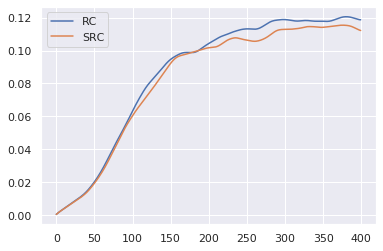

In [19]:
plt.plot(rc_mse[:400])
plt.plot(src_mse[:400])
plt.legend(['RC', 'SRC'])

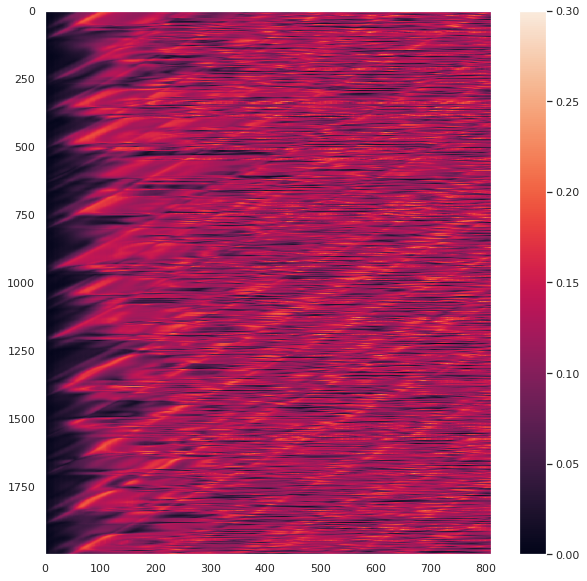

In [15]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
out_test = out_test[:test_len, :]
truth = out_test[:test_len, :].reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)
    
rec_pred = test_rec_pred.reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
test = torch.sqrt(torch.mean(diff**2, dim=2))

plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.3)
plt.grid(b=None)
plt.colorbar()

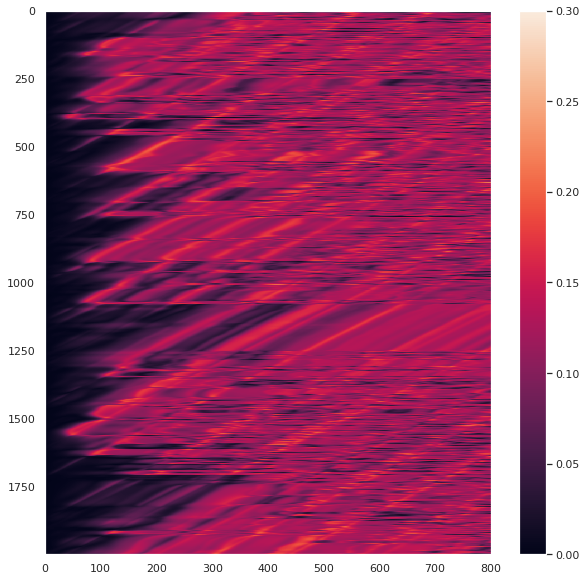

In [12]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(N_test, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
out_test = out_test[:test_len, :]
truth = out_test[:test_len, :].reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)
    
rec_pred = test_rec_pred.reshape(test_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
test = torch.sqrt(torch.mean(diff**2, dim=2))

plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.3)
plt.grid(b=None)
plt.colorbar()

tensor(226)
tensor(0.0071)


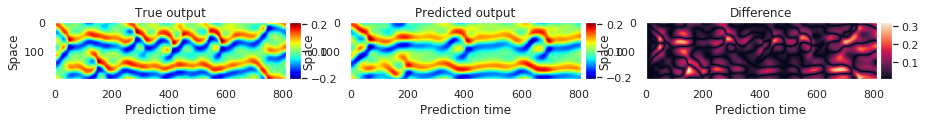

In [16]:
origin = np.argmin(torch.mean(test[:250], dim=1).cpu())
print(origin)
# origin = 800
pred_plot = test_rec_pred[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)[:test_len]

true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(true_plot.T, cmap='jet')
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T, cmap='jet')
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((torch.abs(true_plot-pred_plot)).T)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

print(torch.mean((true_plot-pred_plot)**2))

# Grid search

In [28]:
test_len = 2000
n_rec_pred = test_len
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 2048-input_dim
input_scale = 1.15
res_scale = 0.15
bias_scale = 0
renorm_factor = 1 * np.sqrt(input_dim / n_res)
alpha = 3e-2
leak_rate = 1
# input_scale_vec = np.arange(start=1.05, stop=1.41, step=0.05)
# res_scale_vec = np.arange(start=0., stop=1.21, step=0.05)
bias_scale_vec = np.arange(start=0., stop=0.91, step=0.1)
# renorm_factor_vec = np.arange(start=0.8, stop=1.15, step=0.05)
# renorm_factor_vec = [renorm_factor * np.sqrt(input_dim / n_res) for renorm_factor in renorm_factor_vec]
# alpha_vec = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

err = torch.zeros(len(bias_scale_vec))
for i, bias_scale in tqdm(enumerate(bias_scale_vec)):
    try:
        bias = bias_scale * torch.randn(n_res).to(device)
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', leak_rate=leak_rate, bias=bias, random_projection='structured')
        X = model.forward(u_train_t).to(device)
        X = torch.cat((X, u_train_t*renorm_factor), dim=1)

        output_w = model.train(X, out_train, alpha=alpha)

        Xtest = model.forward(u_test_t[:test_len]).to(device)

        n_rec = 200
        test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)

        new_pred_horizon = pred_horizon_range * (n_rec+1)
        out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
        for pred_horizon in range(1, new_pred_horizon+1):
            out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)[:test_len]

        rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
        truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
        diff = rec_pred - truth
        err[i] = torch.sqrt(torch.mean(diff**2))
    except:
        pass

10it [01:43, 10.37s/it]


tensor([0.0915, 0.1081, 0.1250, 0.1389, 0.1486, 0.1569, 0.1683, 0.1764, 0.1834,
        0.1888])
tensor(0)


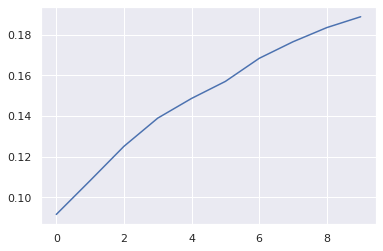

In [29]:
print(err)
print(np.argmin(err.cpu()))
plt.plot(err)

In [27]:
input_scale_vec[4]

1.2500000000000002

# Recurrent Kernels

In [9]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

input_scale = 0.5
res_scale = 0.6
bias_scale = 0.7
renorm_factor = 0.9
alpha = 1e-2
n_iter = 100

print("Training forward")
model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=n_iter,
                           bias_scale=bias_scale)
K = model.forward(u_train_t).to(device)
final_input_gram = u_train_t[n_iter-1:, :] @ u_train_t[n_iter-1:, :].T
K += renorm_factor * final_input_gram

print("Training weights")
output_w = model.train(K, out_train[n_iter-1:, :], alpha=alpha)
del out_train

print("Testing forward")
test_len = 2000
Ktest, diag_res_train, diag_res_test = model.forward_test(u_train_t, u_test_t[:test_len])

print("Testing recursive prediction")
n_rec = 800
# final_train_data = u_train_t[n_iter-1:, :]
# final_test_data = u_test_t[n_iter-1:test_len, :]
# gram_mat = final_test_data @ final_train_data.T
# Ktest += renorm_factor * gram_mat
# test_rec_pred = Ktest @ output_w
test_rec_pred = model.rec_pred_fast(Ktest, u_train_t, u_test_t[:test_len], output_w, n_rec, diag_res_train, diag_res_test, concat=renorm_factor)

Training forward
Training weights
Testing forward
Testing recursive prediction


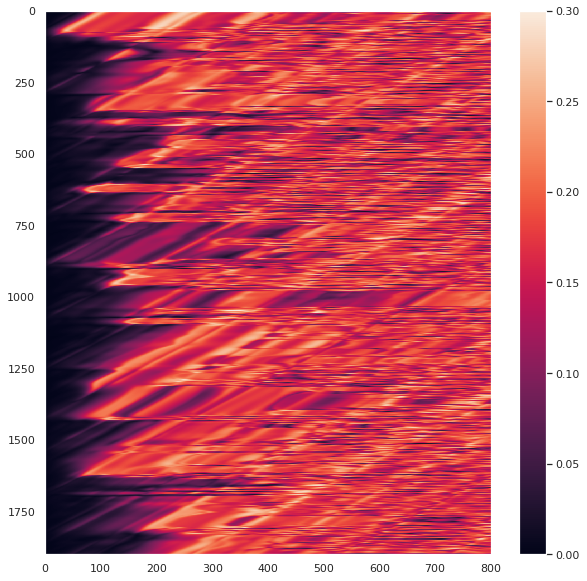

In [10]:
pred_len = test_len - n_iter + 1

new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(N_test - n_iter + 1, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t[n_iter-1:, :], -pred_horizon, dims=0)
out_test = out_test[:pred_len, :]
truth = out_test.reshape(pred_len, (n_rec+1)*pred_horizon_range, input_dim)
    
rec_pred = test_rec_pred.reshape(pred_len, (n_rec+1)*pred_horizon_range, input_dim)

diff = rec_pred - truth.cpu()
test = torch.sqrt(torch.mean(diff**2, dim=2))

plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.3)
plt.grid(b=None)
plt.colorbar()

tensor(166)
tensor(0.0143)


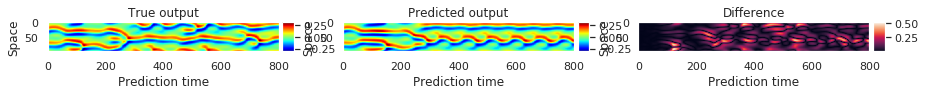

In [12]:
origin = np.argmin(torch.mean(test[:250], dim=1).cpu())
print(origin)
# origin = 800
pred_plot = test_rec_pred[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(test_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t[n_iter-1:, :], -pred_horizon, dims=0)[:test_len]

true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 8))

plot = axes[0].imshow(true_plot.T, cmap='jet')
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T, cmap='jet')
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((torch.abs(true_plot-pred_plot)).T)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

print(torch.mean((true_plot-pred_plot)**2))